In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

## Load data and check basic info

In [4]:
data = pd.read_csv('fraud_oracle.csv')
print(data.head())

  Month  WeekOfMonth  DayOfWeek    Make AccidentArea DayOfWeekClaimed  \
0   Dec            5  Wednesday   Honda        Urban          Tuesday   
1   Jan            3  Wednesday   Honda        Urban           Monday   
2   Oct            5     Friday   Honda        Urban         Thursday   
3   Jun            2   Saturday  Toyota        Rural           Friday   
4   Jan            5     Monday   Honda        Urban          Tuesday   

  MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  ...  AgeOfVehicle  \
0          Jan                   1  Female        Single  ...       3 years   
1          Jan                   4    Male        Single  ...       6 years   
2          Nov                   2    Male       Married  ...       7 years   
3          Jul                   1    Male       Married  ...   more than 7   
4          Feb                   2  Female        Single  ...       5 years   

  AgeOfPolicyHolder PoliceReportFiled WitnessPresent AgentType  \
0          26 to 30 

In [6]:
print(data.shape)
print(data.dtypes)

(15420, 33)
Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     in

In [8]:
# Check for missing values
data.isna().sum() # no explicit missing values

Month                   0
WeekOfMonth             0
DayOfWeek               0
Make                    0
AccidentArea            0
DayOfWeekClaimed        0
MonthClaimed            0
WeekOfMonthClaimed      0
Sex                     0
MaritalStatus           0
Age                     0
Fault                   0
PolicyType              0
VehicleCategory         0
VehiclePrice            0
FraudFound_P            0
PolicyNumber            0
RepNumber               0
Deductible              0
DriverRating            0
Days_Policy_Accident    0
Days_Policy_Claim       0
PastNumberOfClaims      0
AgeOfVehicle            0
AgeOfPolicyHolder       0
PoliceReportFiled       0
WitnessPresent          0
AgentType               0
NumberOfSuppliments     0
AddressChange_Claim     0
NumberOfCars            0
Year                    0
BasePolicy              0
dtype: int64

In [10]:
(data == 0).sum() # Age with value 0 doesn't make sense
data[data['Age'] == 0].head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
7,Nov,1,Friday,Honda,Urban,Tuesday,Mar,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
13,Jan,5,Friday,Honda,Rural,Wednesday,Feb,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
28,Jul,1,Saturday,Honda,Urban,Tuesday,Sep,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils
31,Mar,1,Sunday,Honda,Urban,Tuesday,Mar,2,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
58,May,1,Monday,Honda,Rural,Wednesday,May,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Liability


There are no explicit missing values (NaN), but `Age` with value 0 doesn’t make sense logically.

# EDA

## Target variable distribution

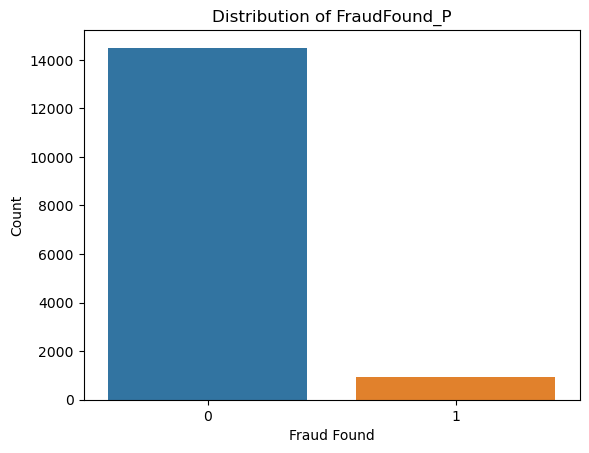

In [15]:
# Target variable distribution
data['FraudFound_P'].value_counts(normalize=True) * 100

sns.countplot(x='FraudFound_P', data=data)
plt.title('Distribution of FraudFound_P')
plt.xlabel('Fraud Found')
plt.ylabel('Count')
plt.show()

Dataset is highly imbalanced, with less than 6% of the claims are fraudulent.

## Examine numerical features

In [19]:
data.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [21]:
# Select numerical features and exclude target variable
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('FraudFound_P')
print("Numerical features:", numerical_features)

Numerical features: ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'PolicyNumber', 'RepNumber', 'Deductible', 'DriverRating', 'Year']


C:\Users\jxlo2\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jxlo2\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jxlo2\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jxlo2\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

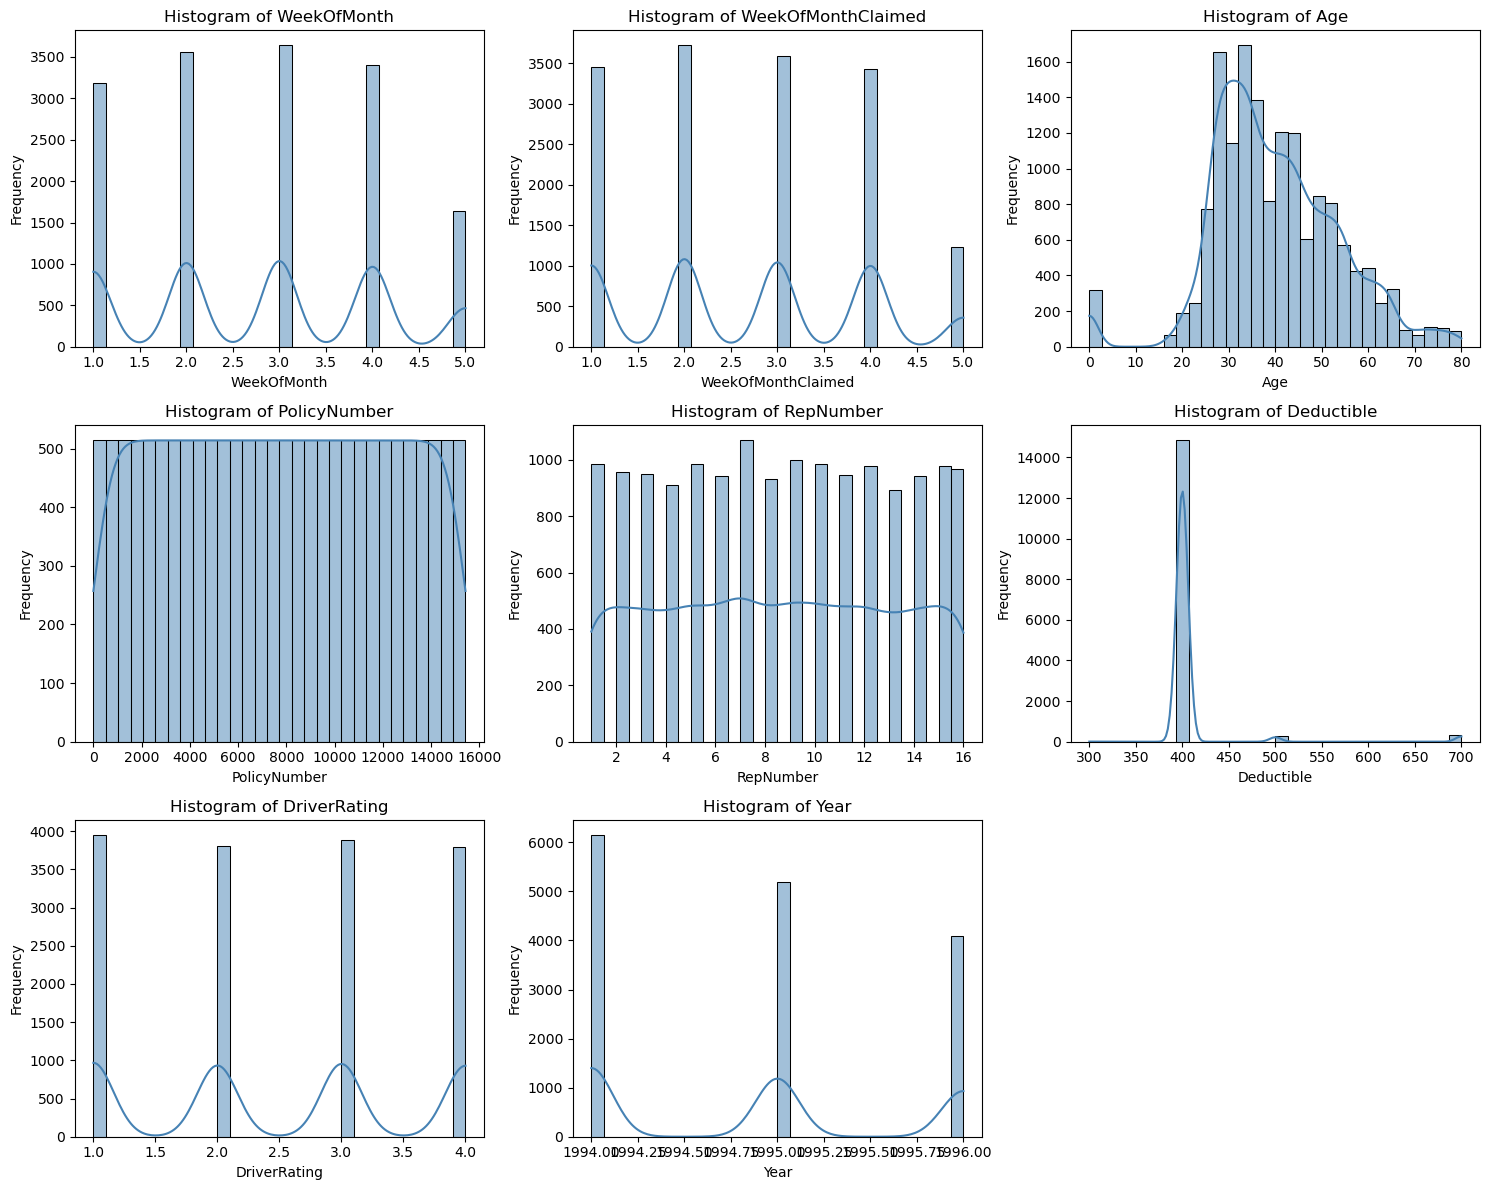

In [23]:
# Histogram
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.histplot(data[col], kde=True, bins=30, color='steelblue', ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Insights:

+ Not all numerical features are continuous
+ RepNumber should be converted to categorical, as there are 16 representatives in total
+ PolicyNumber should be dropped, as it is a unique identifier
+ WeekOfMonth, WeekOfMonthClaimed, and DriverRating are ordinal features.

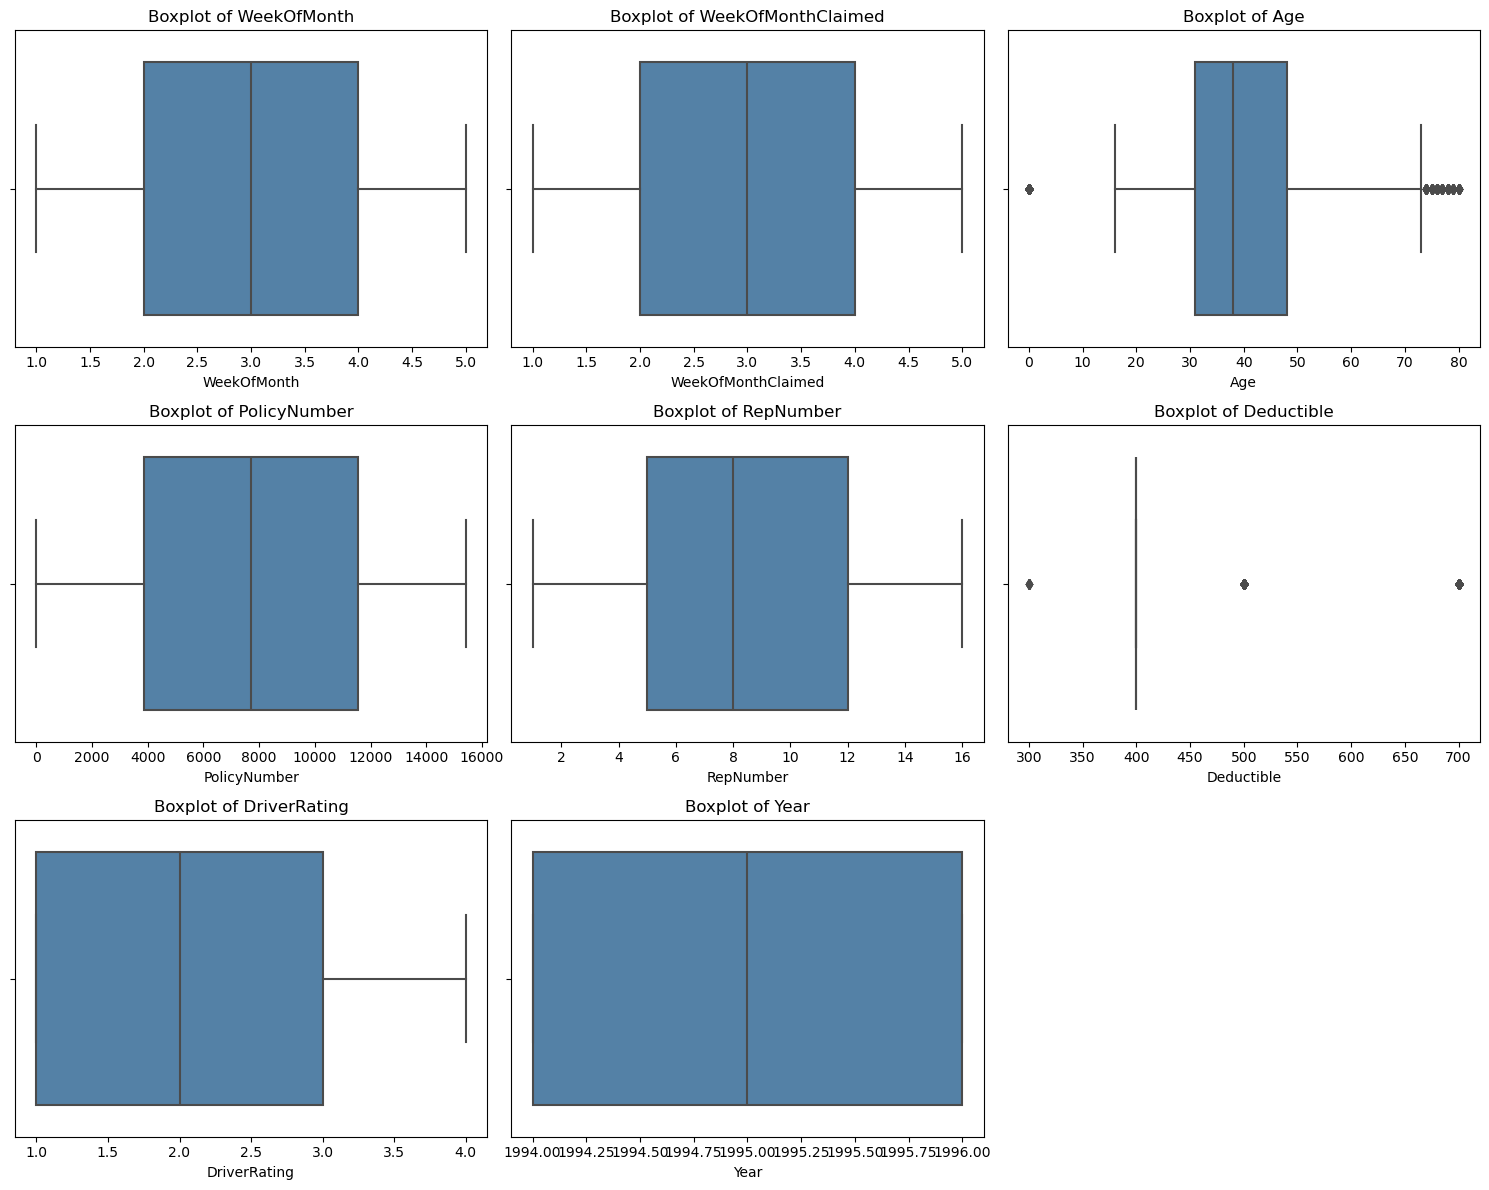

In [26]:
# Boxplot
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    sns.boxplot(x=data[col], color='steelblue', ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Remove unused subplot
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Insights:
+ Outlier of 0 age which doesn't make sense, should be dropped
+ DriverRating is generally low, right-skewed

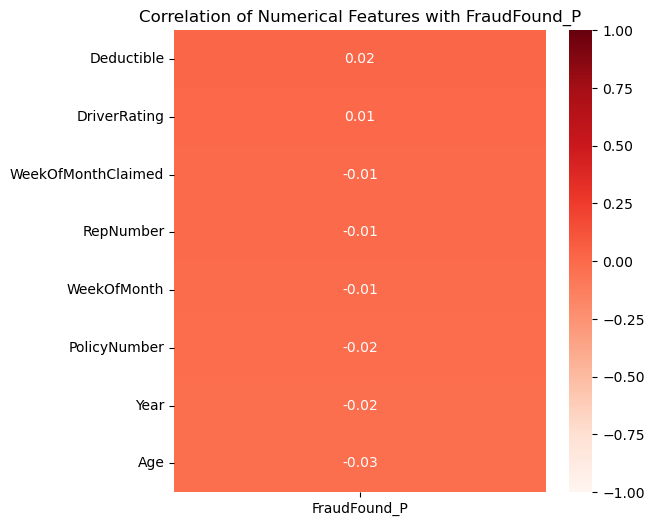

In [29]:
# Correlation with target
cor_target_num = data[numerical_features + ['FraudFound_P']].corr()['FraudFound_P'].sort_values(ascending=False)

plt.figure(figsize=(6,6))
sns.heatmap(cor_target_num[1:].to_frame(), annot=True, cmap='Reds', fmt=".2f", vmin=-1 ,vmax=1)
plt.title("Correlation of Numerical Features with FraudFound_P")
plt.show()


The numerical features show very weak correlation with the target.

## Examining categorical features

In [33]:
df = data.copy()
categorical_cols = df.select_dtypes(include=['object']).columns

In [35]:
df_cat = df[categorical_cols]

In [37]:
# Getting value counts & cardinality of each column
for col in df_cat.columns:
    print(f"\n--- {col} ---")
    print(df_cat[col].value_counts())
    print(f"Cardinality: {df_cat[col].nunique()}")


--- Month ---
Month
Jan    1411
May    1367
Mar    1360
Jun    1321
Oct    1305
Dec    1285
Apr    1280
Feb    1266
Jul    1257
Sep    1240
Nov    1201
Aug    1127
Name: count, dtype: int64
Cardinality: 12

--- DayOfWeek ---
DayOfWeek
Monday       2616
Friday       2445
Tuesday      2300
Thursday     2173
Wednesday    2159
Saturday     1982
Sunday       1745
Name: count, dtype: int64
Cardinality: 7

--- Make ---
Make
Pontiac      3837
Toyota       3121
Honda        2801
Mazda        2354
Chevrolet    1681
Accura        472
Ford          450
VW            283
Dodge         109
Saab          108
Mercury        83
Saturn         58
Nisson         30
BMW            15
Jaguar          6
Porche          5
Mecedes         4
Ferrari         2
Lexus           1
Name: count, dtype: int64
Cardinality: 19

--- AccidentArea ---
AccidentArea
Urban    13822
Rural     1598
Name: count, dtype: int64
Cardinality: 2

--- DayOfWeekClaimed ---
DayOfWeekClaimed
Monday       3757
Tuesday      3375
Wednesday

Categorical columns with different levels of cardinality can be handled differently. For instance, we can perform one-hot encoding for those features with low cardinality, while another method like target encoding can be used for those with high cardinality.

In [40]:
# Fraud rate by category
for col in df_cat.columns:
    print(f"\n--- {col} ---")
    summary = (
        df.groupby(col)['FraudFound_P']
          .agg(total_cases='count',
               fraud_cases='sum',
               fraud_rate='mean')
          .sort_values('fraud_rate', ascending=False)
    )
    print(summary)



--- Month ---
       total_cases  fraud_cases  fraud_rate
Month                                      
Mar           1360          102    0.075000
Aug           1127           84    0.074534
May           1367           94    0.068764
Feb           1266           82    0.064771
Apr           1280           80    0.062500
Jan           1411           87    0.061658
Sep           1240           76    0.061290
Jun           1321           80    0.060560
Oct           1305           70    0.053640
Dec           1285           62    0.048249
Jul           1257           60    0.047733
Nov           1201           46    0.038301

--- DayOfWeek ---
           total_cases  fraud_cases  fraud_rate
DayOfWeek                                      
Sunday            1745          122    0.069914
Saturday          1982          132    0.066599
Friday            2445          154    0.062986
Monday            2616          160    0.061162
Thursday          2173          120    0.055223
Wednesday     

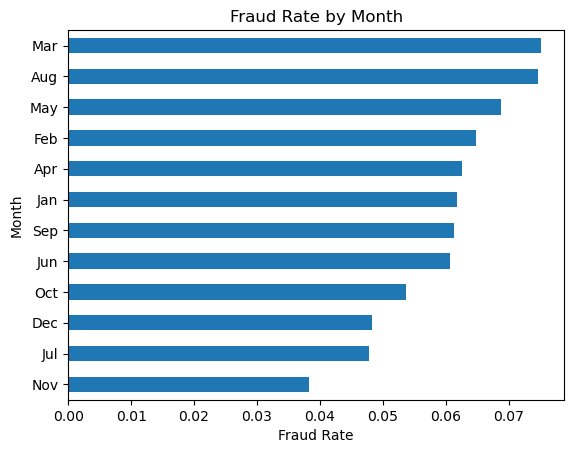

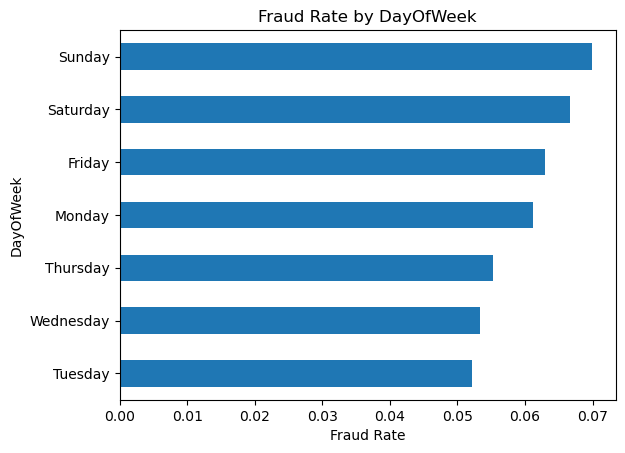

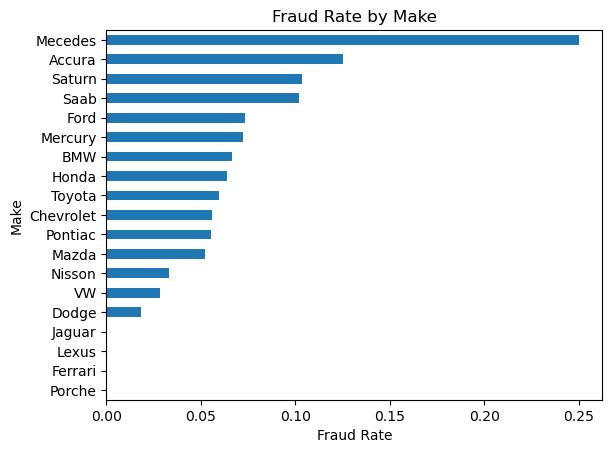

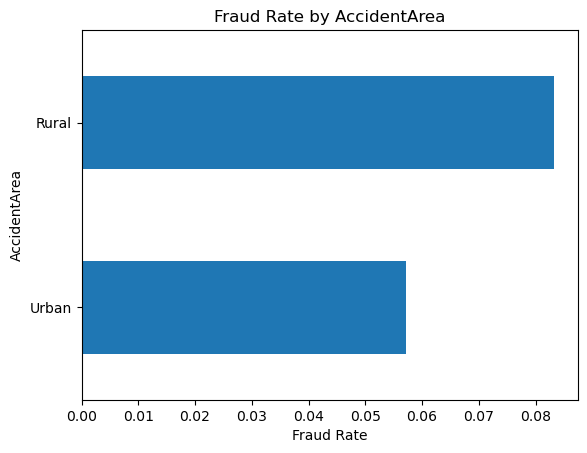

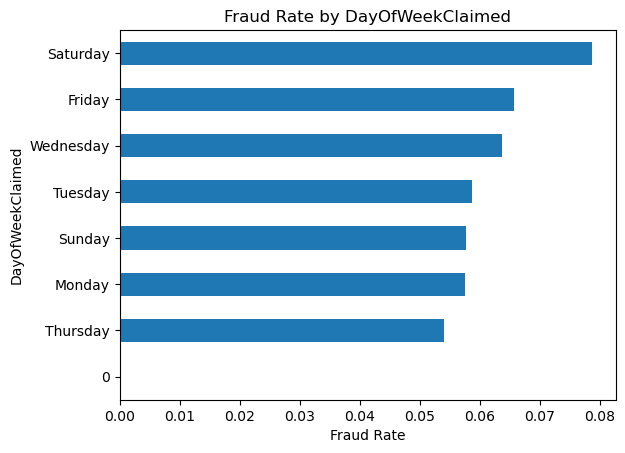

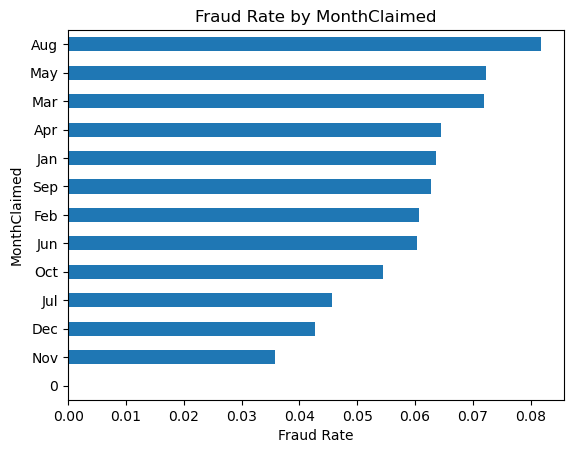

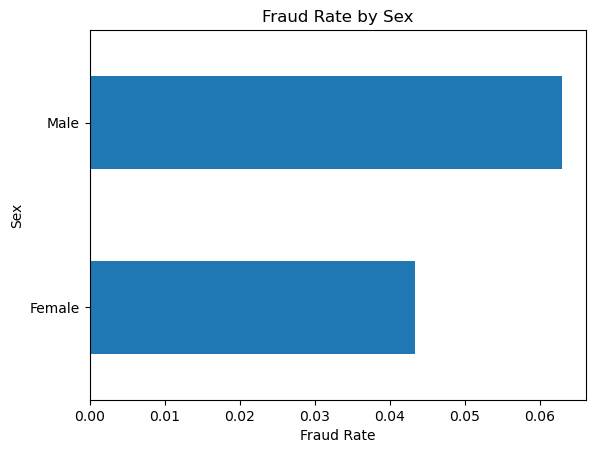

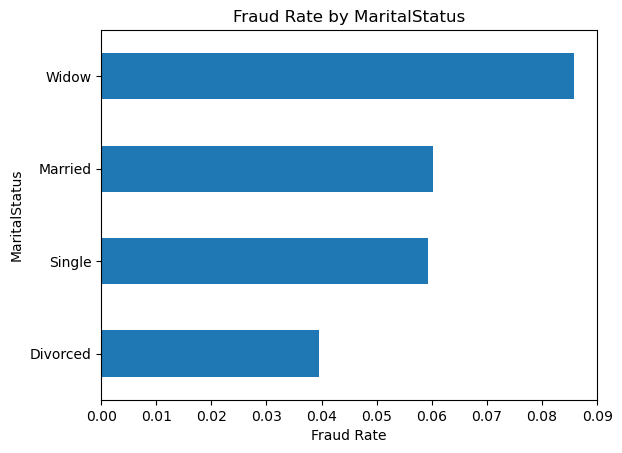

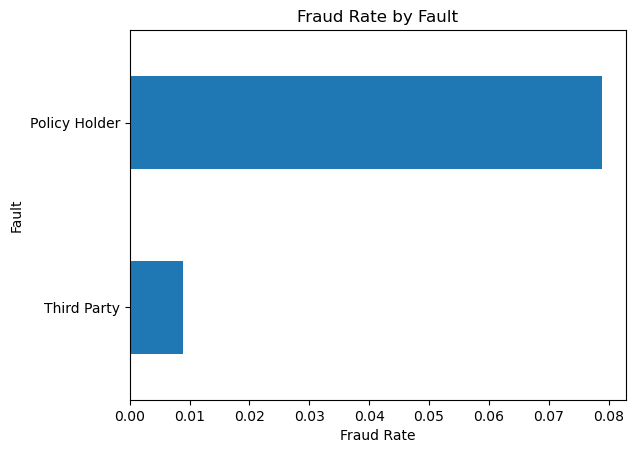

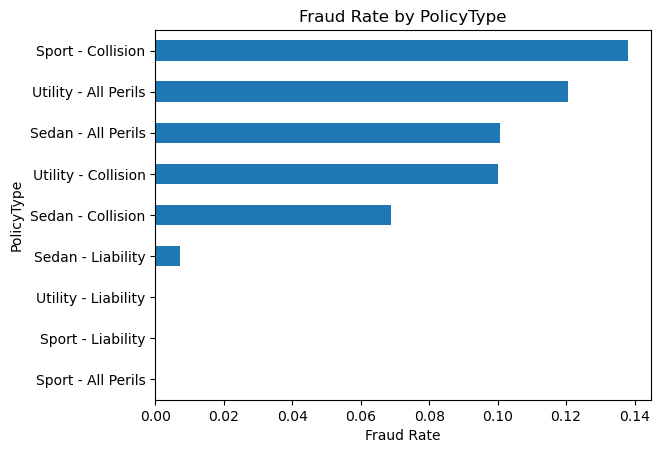

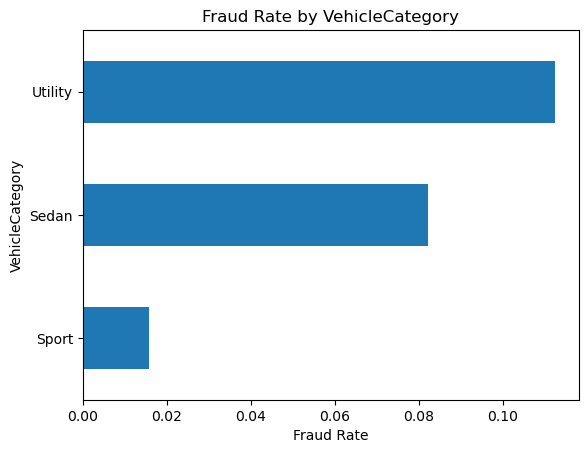

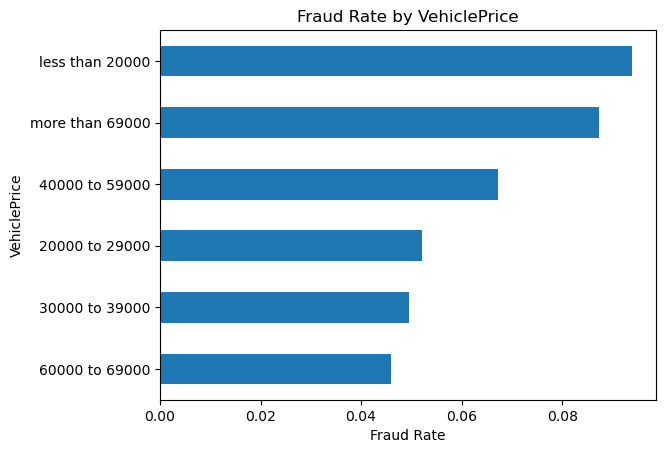

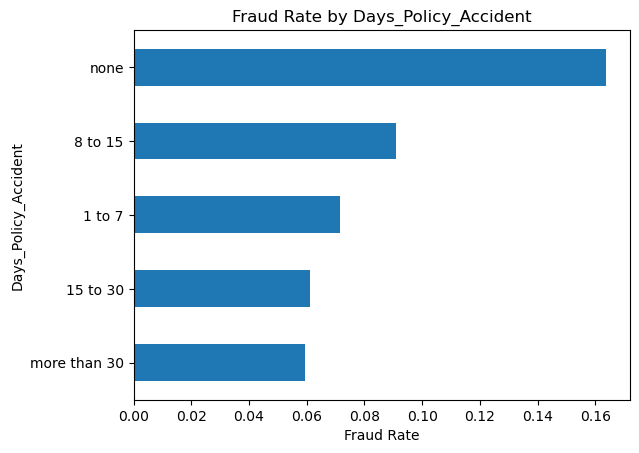

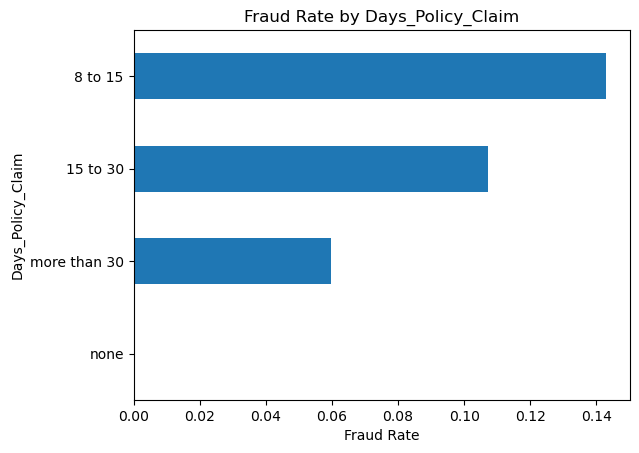

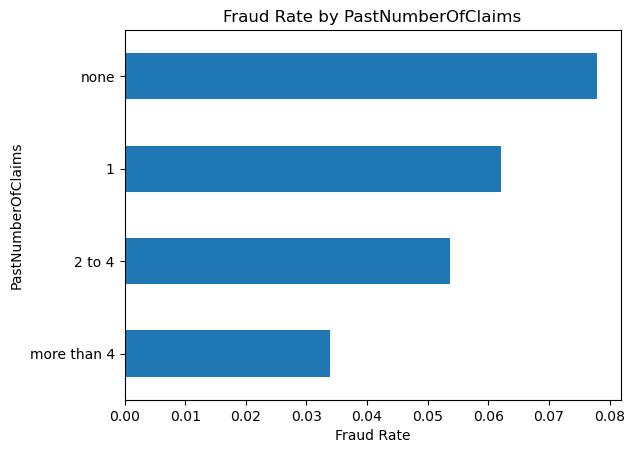

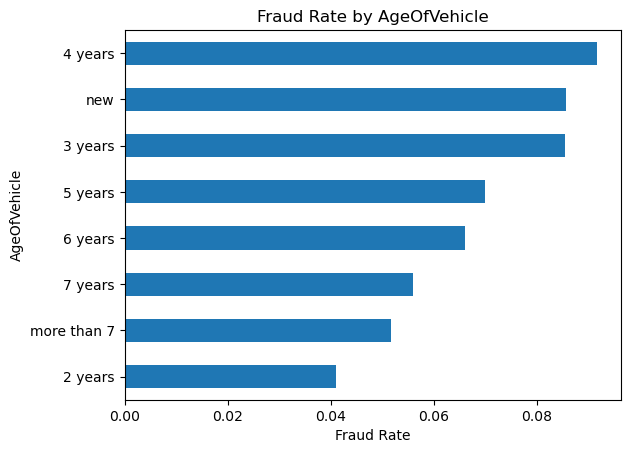

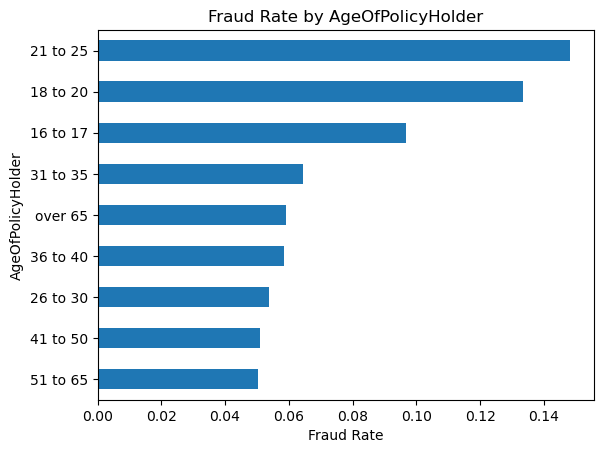

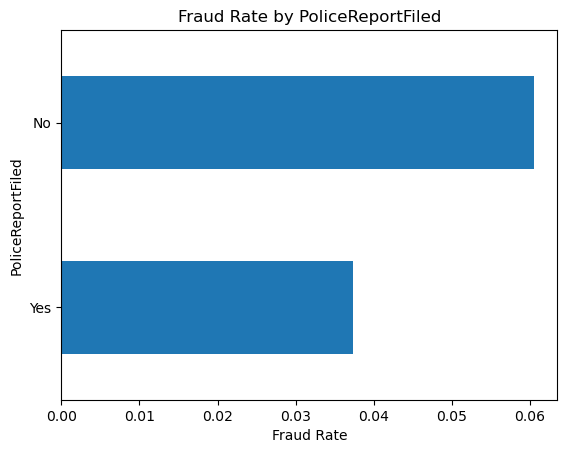

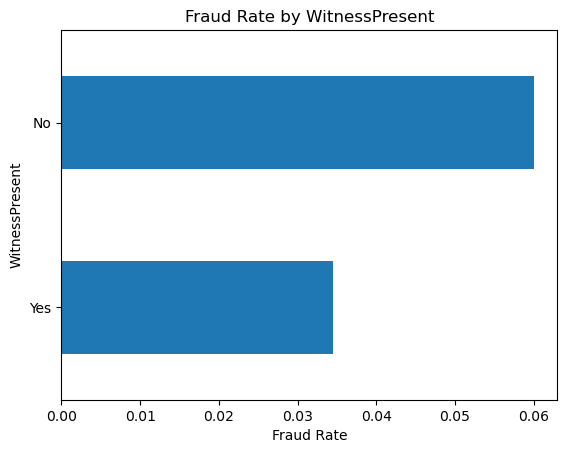

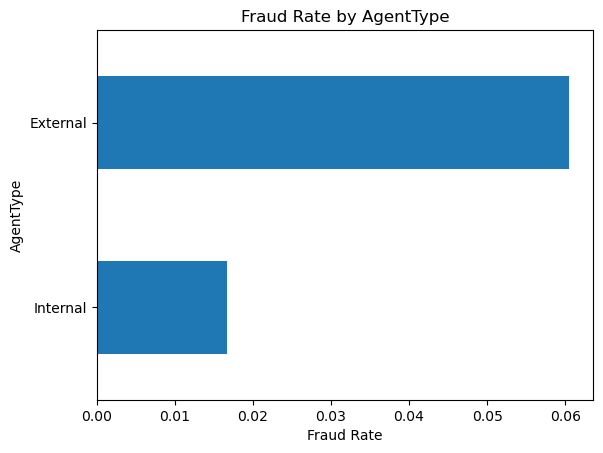

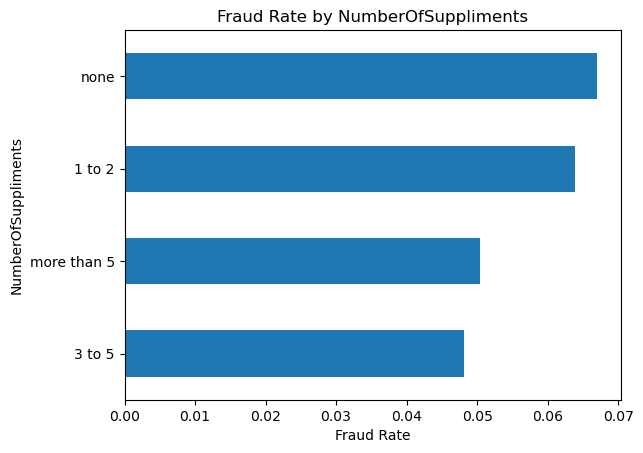

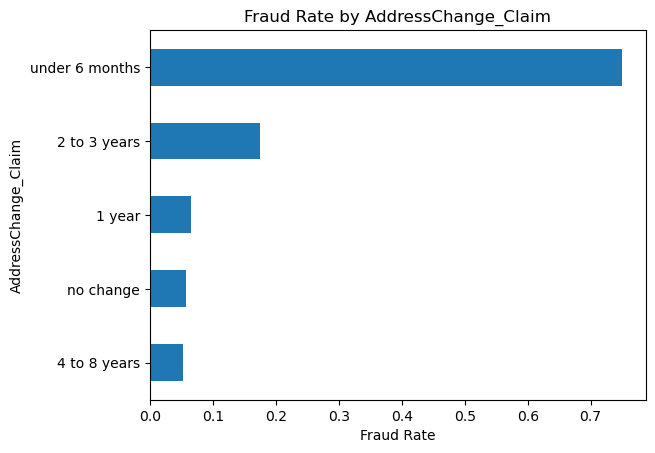

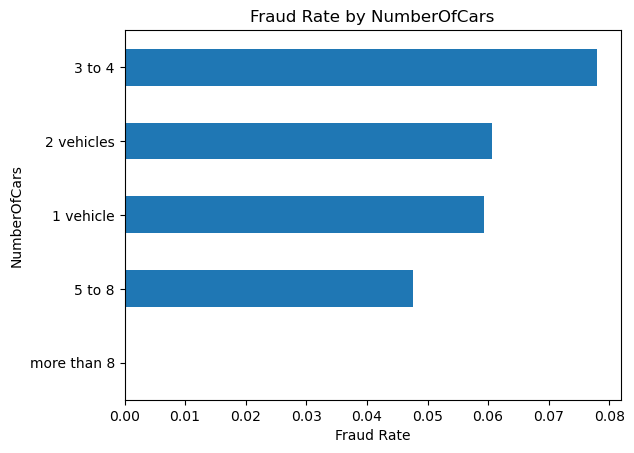

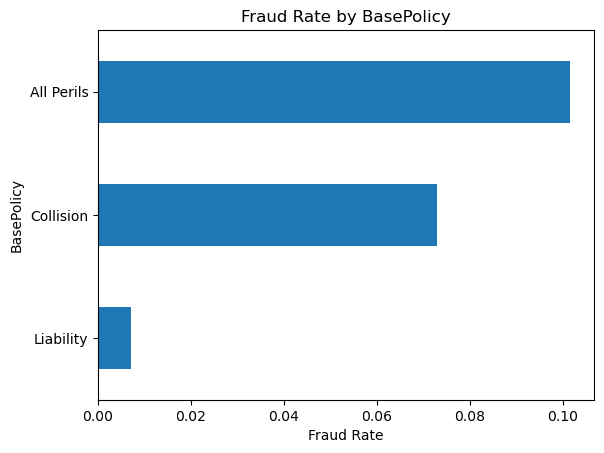

In [42]:
# Visualize fraud rate by category
import matplotlib.pyplot as plt

for col in df_cat.columns:
    df.groupby(col)['FraudFound_P'].mean().sort_values().plot(kind='barh')
    plt.title(f'Fraud Rate by {col}')
    plt.xlabel('Fraud Rate')
    plt.show()

The plots give us a better visualization of the fraud rates corresponding to values in each category. They tell us which values are at higher risk of fraud compared to the other values, for the same category.

In [44]:
# Making a dictionary to rank high-risk values in each category (by decreasing fraud rate)
high_risk_summary = {}

for col in df_cat.columns:
    summary = (
        df.groupby(col)['FraudFound_P']
          .agg(total_cases='count',
               fraud_cases='sum',
               fraud_rate='mean')
          .sort_values('fraud_rate', ascending=False)
    )
    high_risk_summary[col] = summary

In [45]:
# Example: Ranking risky makes of vehicles by decreasing fraud rate
high_risk_summary['Make']

,total_cases,fraud_cases,fraud_rate
Make,,,
Mecedes,4,1,0.250000
Accura,472,59,0.125000
Saturn,58,6,0.103448
Saab,108,11,0.101852
Ford,450,33,0.073333
Mercury,83,6,0.072289
BMW,15,1,0.066667
Honda,2801,179,0.063906
Toyota,3121,186,0.059596


For example, in the 'Make' column, Mercedes is ranked as the most risky with regards to the existence of fraud due to its highest associated fraud rate relative to other makes of vehicles.

### Flagging high-risk values in each category

In [51]:
global_rate = df['FraudFound_P'].mean() # average fraud cases in data

for col in df_cat.columns:
    summary = (
        df.groupby(col)['FraudFound_P']
          .agg(total_cases='count',
               fraud_cases='sum',
               fraud_rate='mean')
          .query(f'fraud_rate > {2 * global_rate}')  # filter high-risk
          .sort_values('fraud_rate', ascending=False)
    )
    print(f"\nHigh-risk categories for {col}:")
    print(summary)


High-risk categories for Month:
Empty DataFrame
Columns: [total_cases, fraud_cases, fraud_rate]
Index: []

High-risk categories for DayOfWeek:
Empty DataFrame
Columns: [total_cases, fraud_cases, fraud_rate]
Index: []

High-risk categories for Make:
         total_cases  fraud_cases  fraud_rate
Make                                         
Mecedes            4            1       0.250
Accura           472           59       0.125

High-risk categories for AccidentArea:
Empty DataFrame
Columns: [total_cases, fraud_cases, fraud_rate]
Index: []

High-risk categories for DayOfWeekClaimed:
Empty DataFrame
Columns: [total_cases, fraud_cases, fraud_rate]
Index: []

High-risk categories for MonthClaimed:
Empty DataFrame
Columns: [total_cases, fraud_cases, fraud_rate]
Index: []

High-risk categories for Sex:
Empty DataFrame
Columns: [total_cases, fraud_cases, fraud_rate]
Index: []

High-risk categories for MaritalStatus:
Empty DataFrame
Columns: [total_cases, fraud_cases, fraud_rate]
Index: []


The above is setting a threshold to flag high risk values in each category, so any values in each category with fraud rate greater than 2 times the global average fraud rate is flagged as “high risk”. This threshold can be varied accordingly, and the global average fraud rate here is just taking the average number of fraud cases in the whole dataset.

## Analyze string-type numerical columns

In [55]:
string_num_features = ['VehiclePrice', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfPolicyHolder', 'NumberOfCars']

for col in string_num_features:
    print(f"{col}:")
    print(data[col].value_counts().sort_index())
    print("\n")


VehiclePrice:
VehiclePrice
20000 to 29000     8079
30000 to 39000     3533
40000 to 59000      461
60000 to 69000       87
less than 20000    1096
more than 69000    2164
Name: count, dtype: int64


Days_Policy_Accident:
Days_Policy_Accident
1 to 7             14
15 to 30           49
8 to 15            55
more than 30    15247
none               55
Name: count, dtype: int64


Days_Policy_Claim:
Days_Policy_Claim
15 to 30           56
8 to 15            21
more than 30    15342
none                1
Name: count, dtype: int64


PastNumberOfClaims:
PastNumberOfClaims
1              3573
2 to 4         5485
more than 4    2010
none           4352
Name: count, dtype: int64


AgeOfPolicyHolder:
AgeOfPolicyHolder
16 to 17     320
18 to 20      15
21 to 25     108
26 to 30     613
31 to 35    5593
36 to 40    4043
41 to 50    2828
51 to 65    1392
over 65      508
Name: count, dtype: int64


NumberOfCars:
NumberOfCars
1 vehicle      14316
2 vehicles       709
3 to 4           372
5 to 8      

Insights:
+ Most features show strong imbalance with one dominant category
+ Days_Policy_Claim: Only 1 case labeled as “none”

# Data Pre-processing



## Handle missing value

In [60]:
# Handling missing/0 values in Age column
print(f"Before Fix:")
print(f"Missing values: {df['Age'].isnull().sum()}")
print(f"Zero values: {(df['Age'] == 0).sum()}")

# Create mapping for numeric version
age_mapping = {
    '16 to 17': 17,
    '18 to 20': 19,
    '21 to 25': 23,
    '26 to 30': 28,
    '31 to 35': 33,
    '36 to 40': 38,
    '41 to 50': 46,
    '51 to 65': 58,
    'over 65': 70
}

# Identify problematic Age values
age_mask = df['Age'].isnull() | (df['Age'] == 0)

# Replace with numeric version of AgeOfPolicyHolder
df.loc[age_mask, 'Age'] = df.loc[age_mask, 'AgeOfPolicyHolder'].map(age_mapping)

Before Fix:
Missing values: 0
Zero values: 320


In [62]:
# Handle any remaining missing
remaining_missing = df['Age'].isnull().sum()
if remaining_missing > 0:
    df['Age'].fillna(int(df['Age'].median()), inplace=True)

print(f"\nAfter fix:")
print(f"Missing values: {df['Age'].isnull().sum()}")
print(f"Zero values: {(df['Age'] == 0).sum()}")


After fix:
Missing values: 0
Zero values: 0


In [64]:
# Handling all other missing values

# Numerical columns
numerical_cols = ['Deductible', 'DriverRating', 'WeekOfMonth', 'WeekOfMonthClaimed']
for col in numerical_cols:
    if col in df.columns and df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0] if len(df[col].mode()) > 0 else 'Unknown', inplace=True)

## Convert string-numeric columns to numeric

In [67]:
# Convert string ranges to numeric -> keep BOTH original string AND numeric version

# Days_Policy_Accident
df['Days_Policy_Accident_numeric'] = df['Days_Policy_Accident'].copy()
df['Days_Policy_Accident_numeric'] = df['Days_Policy_Accident_numeric'].replace({
    'none': 0, '1 to 7': 4, '8 to 15': 12, '15 to 30': 23, 'more than 30': 35
}).astype(int)

In [69]:
# Days_Policy_Claim
df['Days_Policy_Claim_numeric'] = df['Days_Policy_Claim'].copy()
df['Days_Policy_Claim_numeric'] = df['Days_Policy_Claim_numeric'].replace({
    'none': 0, '8 to 15': 12, '15 to 30': 23, 'more than 30': 35
}).astype(int)

In [71]:
# PastNumberOfClaims
df['PastNumberOfClaims_numeric'] = df['PastNumberOfClaims'].copy()
df['PastNumberOfClaims_numeric'] = df['PastNumberOfClaims_numeric'].replace({
    'none': 0, '1': 1, '2 to 4': 3, 'more than 4': 5
}).astype(int)

In [73]:
# AgeOfVehicle
df['AgeOfVehicle_numeric'] = df['AgeOfVehicle'].copy()
df['AgeOfVehicle_numeric'] = df['AgeOfVehicle_numeric'].replace({
    'new': 0, '2 years': 2, '3 years': 3, '4 years': 4,
    '5 years': 5, '6 years': 6, '7 years': 7, 'more than 7': 8
}).astype(int)

In [75]:
# AgeOfPolicyHolder - Keep BOTH string and numeric
df['AgeOfPolicyHolder_numeric'] = df['AgeOfPolicyHolder'].copy()
df['AgeOfPolicyHolder_numeric'] = df['AgeOfPolicyHolder_numeric'].map(age_mapping).astype(int)

In [77]:
# NumberOfSuppliments
df['NumberOfSuppliments_numeric'] = df['NumberOfSuppliments'].copy()
df['NumberOfSuppliments_numeric'] = df['NumberOfSuppliments_numeric'].replace({
    'none': 0, '1 to 2': 2, '3 to 5': 4, 'more than 5': 6
}).astype(int)

In [79]:
# NumberOfCars
df['NumberOfCars_numeric'] = df['NumberOfCars'].copy()
df['NumberOfCars_numeric'] = df['NumberOfCars_numeric'].replace({
    '1 vehicle': 1, '2 vehicles': 2, '3 to 4': 4, '5 to 8': 7, 'more than 8': 9
}).astype(int)

## Feature engineering

In [82]:
# Feature Engineering

# Time-based ratios
df['DaysToClaimRatio'] = df['Days_Policy_Claim_numeric'] / (df['Days_Policy_Accident_numeric'] + 1)

In [84]:
# Age-based features
df['IsYoungDriver'] = (df['Age'] < 21).astype(int)
df['IsOldVehicle'] = (df['AgeOfVehicle_numeric'] > 5).astype(int)
# Corrected AgeVehicleRatio calculation to use numeric age columns
df['AgeVehicleRatio'] = df['AgeOfPolicyHolder_numeric'] / (df['AgeOfVehicle_numeric'] + 1)

In [86]:
# Risk indicators
df['QuickClaim'] = (df['Days_Policy_Claim_numeric'] < 7).astype(int)
df['NoPoliceReport'] = (df['PoliceReportFiled'] == 'No').astype(int)
df['NoWitness'] = (df['WitnessPresent'] == 'No').astype(int)

In [88]:
# Policy features
df['IsNewPolicy'] = (df['Days_Policy_Accident_numeric'] < 30).astype(int)
df['HighDeductible'] = (df['Deductible'] > df['Deductible'].median()).astype(int)

In [90]:
# Frequent Claimant
df['IsFrequentClaimant'] = (df['PastNumberOfClaims_numeric'] > 2).astype(int)

In [92]:
# Address change indicator
df['AddressChanged'] = (df['AddressChange_Claim'] != 'no change').astype(int)

In [94]:
# risk score
df['RiskScore'] = (
    df['QuickClaim'] +
    df['NoPoliceReport'] +
    df['NoWitness'] +
    df['IsNewPolicy'] +
    df['IsFrequentClaimant']
)

In [96]:
print(f"\nFinal dataset shape: {df.shape}")


Final dataset shape: (15420, 52)


In [98]:
# Summary
print("Summary of Risk Indicators:")
print(f"Quick Claims (< 7 days): {df['QuickClaim'].sum()} ({df['QuickClaim'].mean()*100:.2f}%)")
print(f"No Police Report: {df['NoPoliceReport'].sum()} ({df['NoPoliceReport'].mean()*100:.2f}%)")
print(f"No Witness: {df['NoWitness'].sum()} ({df['NoWitness'].mean()*100:.2f}%)")
print(f"New Policies (< 30 days): {df['IsNewPolicy'].sum()} ({df['IsNewPolicy'].mean()*100:.2f}%)")
print(f"Frequent Claimants (> 2 claims): {df['IsFrequentClaimant'].sum()} ({df['IsFrequentClaimant'].mean()*100:.2f}%)")
print(f"Address Changed: {df['AddressChanged'].sum()} ({df['AddressChanged'].mean()*100:.2f}%)")

Summary of Risk Indicators:
Quick Claims (< 7 days): 1 (0.01%)
No Police Report: 14992 (97.22%)
No Witness: 15333 (99.44%)
New Policies (< 30 days): 173 (1.12%)
Frequent Claimants (> 2 claims): 7495 (48.61%)
Address Changed: 1096 (7.11%)


In [100]:
# Check correlation with fraud
if 'FraudFound_P' in df.columns:
    print("Correlation with Fraud:")
    new_features = ['DaysToClaimRatio', 'IsYoungDriver', 'IsOldVehicle', 'AgeVehicleRatio',
                    'QuickClaim', 'NoPoliceReport', 'NoWitness', 'IsNewPolicy',
                    'HighDeductible', 'IsFrequentClaimant', 'RiskScore', 'AddressChanged']
    fraud_corr = df[new_features + ['FraudFound_P']].corr()['FraudFound_P'].sort_values(ascending=False)
    print(fraud_corr)

Correlation with Fraud:
FraudFound_P          1.000000
HighDeductible        0.044249
IsYoungDriver         0.036795
AddressChanged        0.034467
DaysToClaimRatio      0.023512
IsNewPolicy           0.019842
NoPoliceReport        0.016007
NoWitness             0.008057
AgeVehicleRatio       0.005010
QuickClaim           -0.002032
IsOldVehicle         -0.026086
RiskScore            -0.033938
IsFrequentClaimant   -0.047384
Name: FraudFound_P, dtype: float64


### Testing hypotheses to obtain fraud rates for different features

We aim to investigate whether certain behavioural or contextual features are associated with higher incidences of fraud.
Specifically, we test a set of hypotheses suggesting that the presence or absence of particular conditions—such as quick claims, police involvement, or lack of witnesses—may correspond to differing fraud rates.

For each hypothesized feature, we create a binary indicator variable (1 if the condition is met, 0 otherwise) and compute summary statistics showing:

1. the total number of cases,

2. the number of confirmed frauds

3. the observed fraud rate.

This allows us to identify features where fraud occurs disproportionately often, guiding future feature selection steps for later stages of model development.

In [104]:
# Define hypotheses and corresponding features
tests = {
    "Quick Claims (<30 days)":            (df['Days_Policy_Claim_numeric'] < 30).astype(int),
    "Police Report Filed":                (df['PoliceReportFiled'] == 'Yes').astype(int),
    "Witness Present":                    (df['WitnessPresent'] == 'Yes').astype(int),
    "Address Change":                     (df['AddressChange_Claim'] != 'no change').astype(int),
    "Frequent Claimant (>2 past claims)": (df['PastNumberOfClaims_numeric'] > 2).astype(int),
    "New Policy (<30 days)":              (df['Days_Policy_Accident_numeric'] < 30).astype(int),
    "Old Vehicle (>5 years)":             (df['AgeOfVehicle_numeric'] > 5).astype(int),
    "High Deductible (> median)":         (df['Deductible'] > df['Deductible'].median()).astype(int),
}

# For each hypothesis, compute fraud rate summaries
for desc, series in tests.items():
    temp = pd.DataFrame({
        desc: series,
        "FraudFound_P": df["FraudFound_P"]
    })
    summary = (
        temp.groupby(desc)["FraudFound_P"]
        .agg(total_cases="count", fraud_cases="sum", fraud_rate="mean")
    )
    print(f"\n--- {desc} ---")
    print(summary)



--- Quick Claims (<30 days) ---
                         total_cases  fraud_cases  fraud_rate
Quick Claims (<30 days)                                      
0                              15342          914    0.059575
1                                 78            9    0.115385

--- Police Report Filed ---
                     total_cases  fraud_cases  fraud_rate
Police Report Filed                                      
0                          14992          907    0.060499
1                            428           16    0.037383

--- Witness Present ---
                 total_cases  fraud_cases  fraud_rate
Witness Present                                      
0                      15333          920    0.060001
1                         87            3    0.034483

--- Address Change ---
                total_cases  fraud_cases  fraud_rate
Address Change                                      
0                     14324          825    0.057596
1                      1096       

### Plotting fraud rates against the presence/absence of each feature

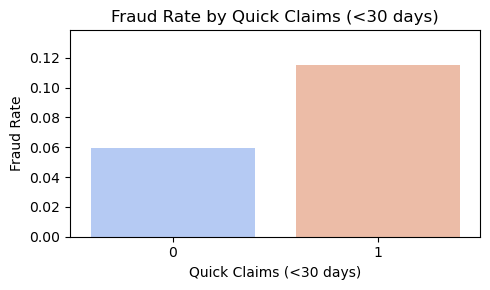

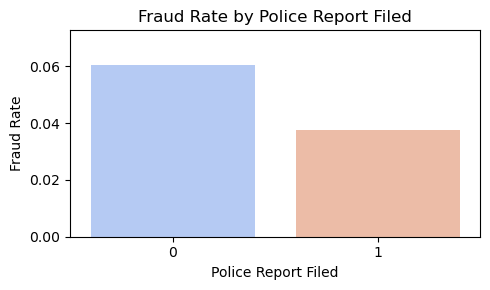

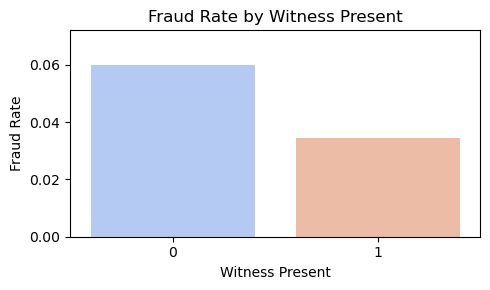

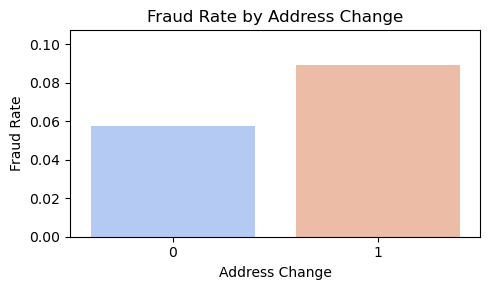

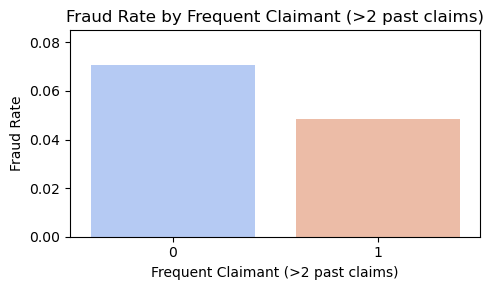

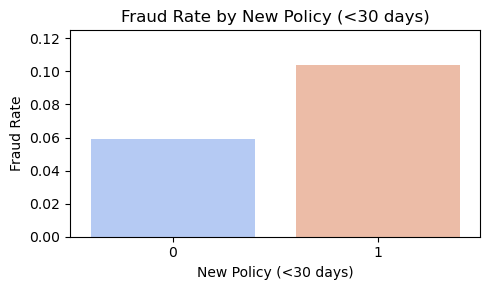

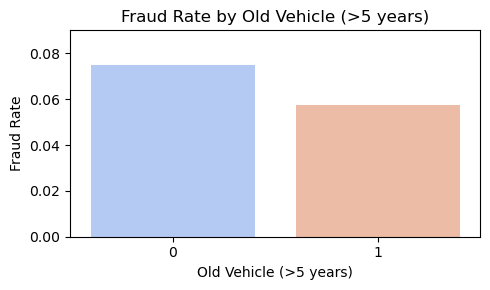

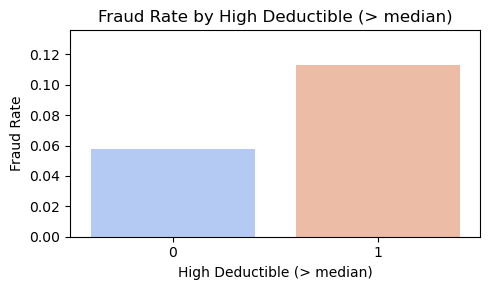

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#Compute and plot each hypothesis separately
for desc, series in tests.items():
    temp = pd.DataFrame({
        desc: series,
        "FraudFound_P": df["FraudFound_P"]
    })
    summary = (
        temp.groupby(desc)["FraudFound_P"]
        .agg(total_cases="count", fraud_cases="sum", fraud_rate="mean")
        .reset_index()
    )

    #Plot each variable as its own figure
    plt.figure(figsize=(5, 3))
    sns.barplot(data=summary, x=desc, y="fraud_rate", palette="coolwarm")
    plt.title(f"Fraud Rate by {desc}")
    plt.ylabel("Fraud Rate")
    plt.ylim(0, summary["fraud_rate"].max() * 1.2)
    plt.tight_layout()
    plt.show()


Key insights from our plots (Threshold for fraud rate gap = 0.04):
1. High Deductible (> median) shows the largest fraud-rate gap (+0.055) — 11.3% vs 5.8%.
→ Policies with higher deductibles are significantly more prone to fraud, possibly because claimants inflate reported damages to recover larger amounts beyond their out-of-pocket cost.

2. Quick Claims (<30 days) and New Policies (<30 days) both show elevated fraud rates (+0.056 and +0.045 respectively).
→ Early claims or newly opened policies are strong red flags for opportunistic or premeditated fraud.

3. Address Change shows a moderate increase (+0.032) — below the 0.04 threshold but still noteworthy.
→ May indicate identity manipulation or relocation used to obscure previous records.

4. Other factors — Police Report Filed, Witness Present, Frequent Claimant (>2 past claims), and Old Vehicle (>5 years) — show differences below 0.04, suggesting no substantial disparity in fraud rates across these groups.


## Encode categorical variables

In [111]:
df

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,IsOldVehicle,AgeVehicleRatio,QuickClaim,NoPoliceReport,NoWitness,IsNewPolicy,HighDeductible,IsFrequentClaimant,AddressChanged,RiskScore
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,0,7.000000,0,1,1,0,0,0,1,2
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,1,4.714286,0,0,1,0,0,0,0,1
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,1,5.750000,0,1,1,0,0,0,0,2
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,1,6.444444,0,0,1,0,0,0,0,1
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,0,5.500000,0,1,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,1,4.714286,0,1,1,0,0,1,0,3
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,1,4.714286,0,1,1,0,0,1,0,3
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,0,4.666667,0,1,1,0,0,1,0,3
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,0,11.000000,0,1,1,0,0,0,0,2


In [113]:
df.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy', 'Days_Policy_Accident_numeric',
       'Days_Policy_Claim_numeric', 'PastNumberOfClaims_numeric',
       'AgeOfVehicle_numeric', 'AgeOfPolicyHolder_numeric',
       'NumberOfSuppliments_numeric', 'NumberOfCars_numeric',
       'DaysToClaimRatio', 'IsYoungDriver', 'IsOldVehicle', 'AgeVehicleRatio',
       'QuickClaim', 'NoPoliceReport', 'NoWitness', 'IsNewPolicy',
       'HighDeductible', 'IsFrequentClaimant', '

In [115]:
df['Month'].value_counts()

Month
Jan    1411
May    1367
Mar    1360
Jun    1321
Oct    1305
Dec    1285
Apr    1280
Feb    1266
Jul    1257
Sep    1240
Nov    1201
Aug    1127
Name: count, dtype: int64

In [117]:
#convert Month to numerical
df['Month_Numerical'] = df['Month'].apply(lambda x: datetime.datetime.strptime(x, "%b").month)

In [119]:
df['MonthClaimed'].value_counts()

MonthClaimed
Jan    1446
May    1411
Mar    1348
Oct    1339
Jun    1293
Feb    1287
Nov    1285
Apr    1271
Sep    1242
Jul    1225
Dec    1146
Aug    1126
0         1
Name: count, dtype: int64

In [121]:
#discovered a 0 in MonthClaimed, replaced with the month column in that row
df['MonthClaimed'] = df['MonthClaimed'].replace('0', 'Jul')

In [123]:
#convert MonthClaimed to numerical
df['MonthClaimed_Numerical'] = df['MonthClaimed'].apply(lambda x: datetime.datetime.strptime(x, "%b").month)

In [125]:
#convert DayOfWeek to numerical
day_map = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}
df['DayOfWeek_Numerical'] = df['DayOfWeek'].map(day_map)

In [127]:
df['DayOfWeekClaimed'].value_counts()

DayOfWeekClaimed
Monday       3757
Tuesday      3375
Wednesday    2951
Thursday     2660
Friday       2497
Saturday      127
Sunday         52
0               1
Name: count, dtype: int64

In [129]:
#discovered a 0 in DayOfWeekClaimed, replaced with the DayOfWeek column in that row
df['DayOfWeekClaimed'] = df['DayOfWeekClaimed'].replace('0', 'Monday')
df['DayOfWeekClaimed_Numerical'] = df['DayOfWeekClaimed'].map(day_map)

In [131]:
df['Make'].value_counts()

Make
Pontiac      3837
Toyota       3121
Honda        2801
Mazda        2354
Chevrolet    1681
Accura        472
Ford          450
VW            283
Dodge         109
Saab          108
Mercury        83
Saturn         58
Nisson         30
BMW            15
Jaguar          6
Porche          5
Mecedes         4
Ferrari         2
Lexus           1
Name: count, dtype: int64

In [133]:
#encoding needs to be tailored for specific models that we are using (e.g. label encoding if using tree-based model, one-hot for linear model...)
#created two types of encoding for different needs but more could be created to properly fit to whichever model we using subsequently
le = LabelEncoder()
df['Make_label_encoded'] = le.fit_transform(df['Make'])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)
make_freq = df['Make'].value_counts(normalize=True)
df['Make_frequency_encoded'] = df['Make'].map(make_freq)

{'Accura': 0, 'BMW': 1, 'Chevrolet': 2, 'Dodge': 3, 'Ferrari': 4, 'Ford': 5, 'Honda': 6, 'Jaguar': 7, 'Lexus': 8, 'Mazda': 9, 'Mecedes': 10, 'Mercury': 11, 'Nisson': 12, 'Pontiac': 13, 'Porche': 14, 'Saab': 15, 'Saturn': 16, 'Toyota': 17, 'VW': 18}


In [135]:
df['AccidentArea'].value_counts()

AccidentArea
Urban    13822
Rural     1598
Name: count, dtype: int64

In [137]:
#encode accidentarea
area_map = {'Rural': 0, 'Urban': 1}
df['AccidentArea_encoded'] = df['AccidentArea'].map(area_map)

In [139]:
df['Sex'].value_counts()

Sex
Male      13000
Female     2420
Name: count, dtype: int64

In [141]:
#encode sex
sex_map = {'Male': 1, 'Female': 0}
df['Sex_encoded'] = df['Sex'].map(sex_map)

In [143]:
df['MaritalStatus'].value_counts()

MaritalStatus
Married     10625
Single       4684
Divorced       76
Widow          35
Name: count, dtype: int64

In [145]:
#encode maritalstatus
marital_map = {'Married': 0, 'Single': 1, 'Divorced': 2, 'Widow': 3}
df['MaritalStatus_encoded'] = df['MaritalStatus'].map(marital_map)

In [147]:
df['Fault'].value_counts()

Fault
Policy Holder    11230
Third Party       4190
Name: count, dtype: int64

In [149]:
#encode fault
fault_map = {'Policy Holder': 0, 'Third Party': 1}
df['Fault_encoded'] = df['Fault'].map(fault_map)

In [151]:
#check if PolicyType matches with VehicleCategory
vehicle_in_policytype = df['PolicyType'].str.split(' - ').str[0]
vehicle_in_policytype == df['VehicleCategory']

0         True
1         True
2         True
3        False
4         True
         ...  
15415     True
15416    False
15417     True
15418     True
15419     True
Length: 15420, dtype: bool

In [153]:
(vehicle_in_policytype == df['VehicleCategory']).sum()

10433

In [155]:
df['VehiclePrice'].value_counts()

VehiclePrice
20000 to 29000     8079
30000 to 39000     3533
more than 69000    2164
less than 20000    1096
40000 to 59000      461
60000 to 69000       87
Name: count, dtype: int64

In [157]:
#encode VehiclePrice
vehicleprice_map = {
    'less than 20000': 0,
    '20000 to 29000' : 1,
    '30000 to 39000': 2,
    '40000 to 59000': 3,
    '60000 to 69000': 4,
    'more than 69000': 5
}
df['VehiclePrice_encoded'] = df['VehiclePrice'].map(vehicleprice_map)

In [159]:
df['PoliceReportFiled'].value_counts()

PoliceReportFiled
No     14992
Yes      428
Name: count, dtype: int64

In [161]:
#encode PoliceReportFiled
PoliceReportFiled_map = {
    'No': 0,
    'Yes' : 1
}
df['PoliceReportFiled_encoded'] = df['PoliceReportFiled'].map(PoliceReportFiled_map)

In [163]:
df['WitnessPresent'].value_counts()

WitnessPresent
No     15333
Yes       87
Name: count, dtype: int64

In [165]:
#encode WitnessPresent
WitnessPresent_map = {
    'No': 0,
    'Yes' : 1
}
df['WitnessPresent_encoded'] = df['WitnessPresent'].map(WitnessPresent_map)

In [167]:
df['AgentType'].value_counts()

AgentType
External    15179
Internal      241
Name: count, dtype: int64

In [169]:
#encode AgentType
AgentType_map = {
    'External': 0,
    'Internal' : 1
}
df['AgentType_encoded'] = df['AgentType'].map(AgentType_map)

In [171]:
df['AddressChange_Claim'].value_counts()

AddressChange_Claim
no change         14324
4 to 8 years        631
2 to 3 years        291
1 year              170
under 6 months        4
Name: count, dtype: int64

In [173]:
#encode AddressChange_Claim
AddressChange_Claims_map = {
    'no change': 0,
    'under 6 months' : 1,
    '1 year': 2,
    '2 to 3 years': 3,
    '4 to 8 years': 4}
df['AddressChange_Claim_encoded'] = df['AddressChange_Claim'].map(AddressChange_Claims_map)

In [175]:
df['BasePolicy'].value_counts()

BasePolicy
Collision     5962
Liability     5009
All Perils    4449
Name: count, dtype: int64

In [177]:
#encode BasePolicy
BasePolicy_map = {
    'Collision': 0,
    'Liability' : 1,
    'All Perils': 2
}
df['BasePolicy_encoded'] = df['BasePolicy'].map(BasePolicy_map)

## Outlier

In [180]:
# Select numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('FraudFound_P')

for col in numerical_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")


WeekOfMonth: 0 outliers
WeekOfMonthClaimed: 0 outliers
Age: 227 outliers
PolicyNumber: 0 outliers
RepNumber: 0 outliers
Deductible: 582 outliers
DriverRating: 0 outliers
Year: 0 outliers
DaysToClaimRatio: 177 outliers
AgeVehicleRatio: 1449 outliers
Month_Numerical: 0 outliers
MonthClaimed_Numerical: 0 outliers
DayOfWeek_Numerical: 0 outliers
DayOfWeekClaimed_Numerical: 0 outliers
Make_frequency_encoded: 1626 outliers
AccidentArea_encoded: 1598 outliers
Sex_encoded: 2420 outliers
MaritalStatus_encoded: 35 outliers
Fault_encoded: 0 outliers
VehiclePrice_encoded: 2251 outliers
PoliceReportFiled_encoded: 428 outliers
WitnessPresent_encoded: 87 outliers
AgentType_encoded: 241 outliers
AddressChange_Claim_encoded: 1096 outliers
BasePolicy_encoded: 0 outliers


## Train-test split

In [183]:
X = df.drop(columns=['FraudFound_P'])
y = df['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check resulting shapes
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (12336, 67)
Test shape: (3084, 67)


## Resampling

In [186]:
# SMOTE
from imblearn.over_sampling import SMOTE

# Select only numeric columns
X_train_numeric = X_train.select_dtypes(include=[np.number])
y_train_numeric = y_train.astype(int)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_numeric, y_train_numeric)

print("After SMOTE shape:", X_train_smote.shape)
print("Class distribution after SMOTE:\n", pd.Series(y_train_smote).value_counts())


After SMOTE shape: (23196, 43)
Class distribution after SMOTE:
 FraudFound_P
0    11598
1    11598
Name: count, dtype: int64


SMOTE generates synthetic examples of the minority class (fraudulent claims) by interpolating between existing minority samples.

It is suitable because:
- fraud class is extremely imbalanced (~6%)
=> SMOTE helps the model learn patterns in the minority class without duplicating existing samples, reducing overfitting compared to simple oversampling

**Result**: Perfectly balanced (11,598 vs 11,598)

**Implication**: The model will see equal numbers of fraud and non-fraud cases, which usually improves learning of the minority class

**Caveat**: SMOTE only creates synthetic minority samples, doesn’t remove any majority samples, so noisy majority examples remain

In [190]:
# SMOTEENN
from imblearn.combine import SMOTEENN

# Apply SMOTEENN
smote_enn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train_numeric, y_train_numeric)

print("After SMOTEENN shape:", X_train_smoteenn.shape)
print("Class distribution after SMOTEENN:\n", pd.Series(y_train_smoteenn).value_counts())

After SMOTEENN shape: (17071, 43)
Class distribution after SMOTEENN:
 FraudFound_P
1    10620
0     6451
Name: count, dtype: int64


SMOTEENN combines SMOTE (Synthetic Minority Oversampling Technique) with Edited Nearest Neighbors (ENN) undersampling. SMOTE creates synthetic samples for the minority class (fraud cases), while ENN removes noisy or borderline examples from the majority class (non-fraud).

It is suitable because
- dataset is highly imbalanced (~6% fraud)
=> SMOTE generates additional fraud cases to improve model learning

- many outliers in numerical and categorical features
=> ENN helps clean noisy samples from the majority class, reducing the risk of overfitting

=> Handles complex, nonlinear relationships


**Result**: Imbalanced toward the minority class (11,593 fraud vs 7,507 non-fraud)

**Implication**: This method removes majority samples that are close to minority examples (cleaning noise), while also generating synthetic minority examples

**Effect on performance**: Can improve minority detection (higher recall) but may slightly reduce overall accuracy, because some majority examples are **removed**

In [194]:
#SMOTETomek
from imblearn.combine import SMOTETomek

# Apply SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smote_tomek.fit_resample(X_train_numeric, y_train_numeric)

print("After SMOTETomek shape:", X_train_smotetomek.shape)
print("Class distribution after SMOTETomek:\n", pd.Series(y_train_smotetomek).value_counts())

After SMOTETomek shape: (22922, 43)
Class distribution after SMOTETomek:
 FraudFound_P
0    11461
1    11461
Name: count, dtype: int64


SMOTETomek combines SMOTE with Tomek Links undersampling, which removes overlapping or borderline majority samples that are closest to minority samples.

It is suitable because:
- it helps to balance the highly skewed classes by oversampling fraud cases
- it reduces overlap between fraud and non-fraud cases, improving the classifier’s ability to distinguish subtle differences in this noisy, high-dimensional dataset
- less aggressive than SMOTEENN in removing samples, so it preserves more data while still addressing imbalance


**Result**: Perfectly balanced (11,597 vs 11,597)

**Implication**: Similar to SMOTE, but removes overlapping majority-minority pairs (Tomek links)

**Effect on performance**: Reduces class overlap and noise, often improving both precision and recall compared to plain SMOTE

In [198]:
# KMeans-SMOTE
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import MiniBatchKMeans

# Define the clustering estimator
kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)

# Initialize KMeansSMOTE with the clustering estimator
kmeans_smote = KMeansSMOTE(
    random_state=42,
    kmeans_estimator=kmeans,
    cluster_balance_threshold=0.01  # Adjust as needed
)

# Apply KMeansSMOTE to your data
X_train_kmeans, y_train_kmeans = kmeans_smote.fit_resample(X_train_numeric, y_train_numeric)

# Check the results
print("After KMeansSMOTE shape:", X_train_kmeans.shape)
print("Class distribution after KMeansSMOTE:\n", pd.Series(y_train_kmeans).value_counts())


C:\Users\jxlo2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\jxlo2\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 3072 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


After KMeansSMOTE shape: (23198, 43)
Class distribution after KMeansSMOTE:
 FraudFound_P
1    11600
0    11598
Name: count, dtype: int64


KMeans-SMOTE first clusters the data (e.g., using KMeans) and then applies SMOTE within each cluster. This creates synthetic minority samples that respect the local distribution of each cluster.

It is suitable because:
- dataset has high dimensionality and heterogeneous feature types (numerical + categorical)
=> KMeans-SMOTE generates minority samples within clusters, which prevents unrealistic synthetic points
- reduces the risk of extrapolation into feature space regions without real data, which is a problem with vanilla SMOTE in complex datasets
- maintains the underlying fraud patterns while improving class balance


**Result**: Nearly perfectly balanced (11,600 fraud vs 11,598 non-fraud)

**Implication**: Uses clustering to generate synthetic minority samples in dense regions. Preserves minority structure and reduces risk of generating unrealistic samples

**Effect on performance**: Usually better minority class learning with less risk of overfitting, especially in high-dimensional datasets

In [202]:
def plot_class_distribution(y_before, y_after, title_before, title_after):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=y_before, ax=axes[0])
    axes[0].set_title(title_before)
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')

    sns.countplot(x=y_after, ax=axes[1])
    axes[1].set_title(title_after)
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


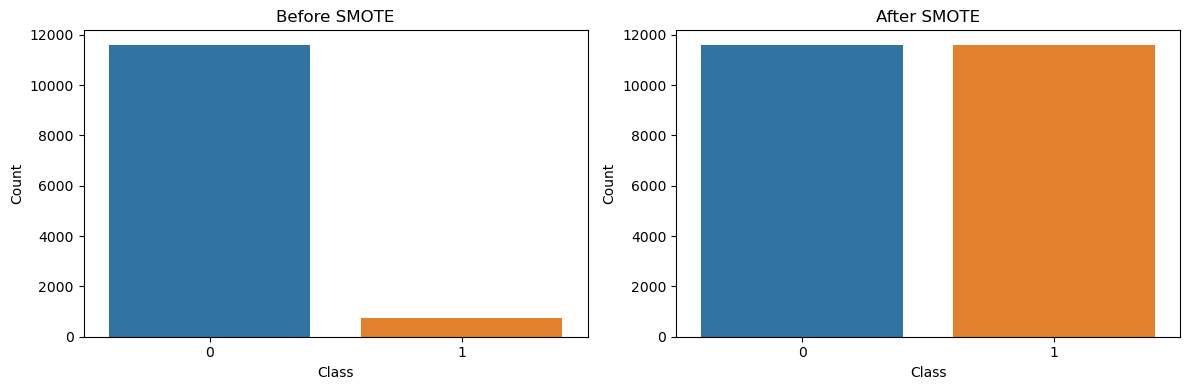

In [204]:
# Plot class distribution for SMOTE
plot_class_distribution(y_train_numeric, y_train_smote, "Before SMOTE", "After SMOTE")


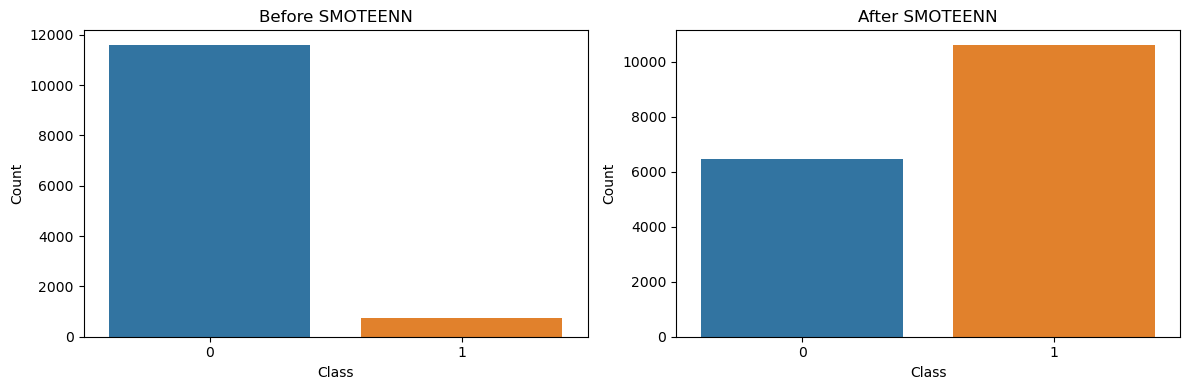

In [206]:
# Plot class distribution for SMOTEENN
plot_class_distribution(y_train_numeric, y_train_smoteenn, "Before SMOTEENN", "After SMOTEENN")


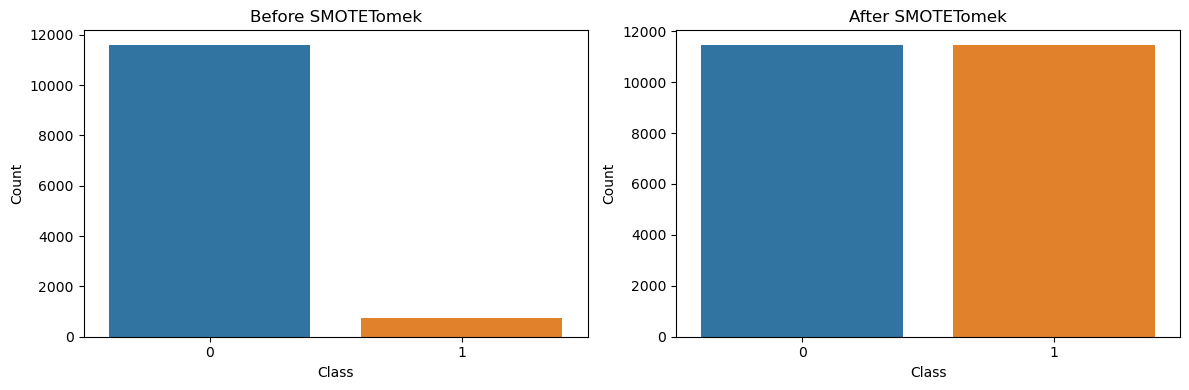

In [208]:
# Plot class distribution for SMOTETomek
plot_class_distribution(y_train_numeric, y_train_smotetomek, "Before SMOTETomek", "After SMOTETomek")


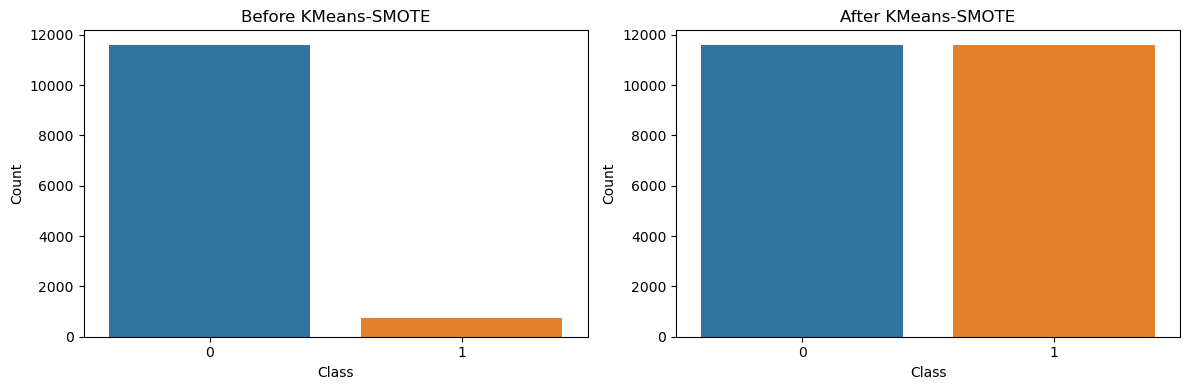

In [210]:
# Plot class distribution for KMeans-SMOTE
plot_class_distribution(y_train_numeric, y_train_kmeans, "Before KMeans-SMOTE", "After KMeans-SMOTE")


A balanced class distribution doesn’t guarantee better performance
- Over-sampling might introduce synthetic data that is noisy or unrealistic →=> model may overfit
- Under-sampling (e.g., part of SMOTEENN) removes some majority examples =? model may lose important information

Even if the dataset is perfectly balanced, the model may still struggle to generalize on the real test set if the minority class is complex or noisy

Hence perform evaluation on the test set:
- **Recall** (How many real frauds caught)
- **F1-score** (Balance between precision and recall)
- **ROC-AUC / PR-AUC** (Performance across all thresholds, especially useful for imbalanced datasets)

               Recall  F1-score   ROC-AUC    PR-AUC
SMOTE        0.054054  0.087719  0.756222  0.143531
SMOTEENN     0.113514  0.128049  0.764714  0.131289
SMOTETomek   0.032432  0.053333  0.757313  0.141176
KMeansSMOTE  0.043243  0.077295  0.879533  0.269555


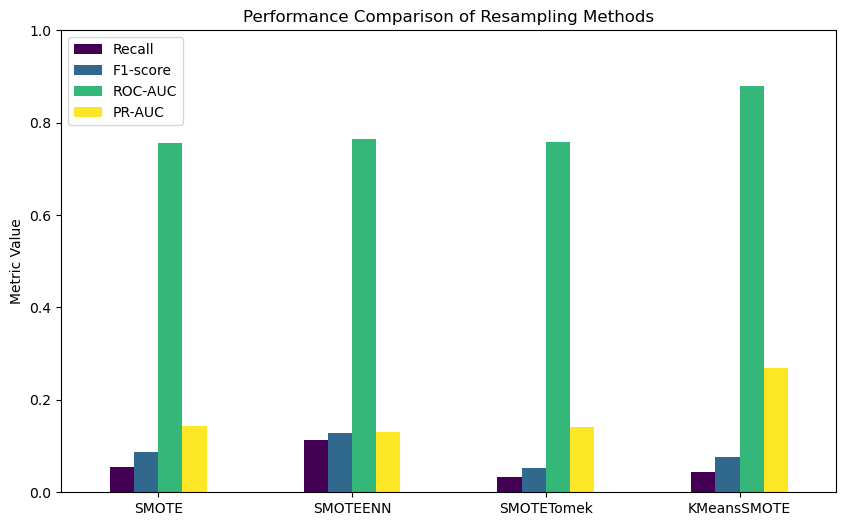

In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Convert X_test to numeric (to match resampled training sets)
X_test_numeric = X_test.select_dtypes(include=[np.number])

# Dictionary to store results
results = {}

# List of resampled datasets
resampled_data = {
    "SMOTE": (X_train_smote, y_train_smote),
    "SMOTEENN": (X_train_smoteenn, y_train_smoteenn),
    "SMOTETomek": (X_train_smotetomek, y_train_smotetomek),
    "KMeansSMOTE": (X_train_kmeans, y_train_kmeans)
}

# Train and evaluate for each resampling method
for name, (X_res, y_res) in resampled_data.items():
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_res, y_res)

    # Predict on test set
    y_pred = clf.predict(X_test_numeric)
    y_prob = clf.predict_proba(X_test_numeric)[:, 1]

    # Metrics
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    precision, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall_curve, precision)

    results[name] = {"Recall": recall, "F1-score": f1, "ROC-AUC": roc_auc, "PR-AUC": pr_auc}

# Convert to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

# Plot metrics comparison
results_df.plot(kind='bar', figsize=(10,6), colormap='viridis')
plt.title("Performance Comparison of Resampling Methods")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.show()


**Results**:
1) **Recall**:
SMOTEENN performs the best, identifying 14% of the fraud cases correclty =>
SMOTEENN’s combination of oversampling and cleaning helped the model focus on minority cases

2) **F1-score**:
SMOTEENN is the best => balances detection and precision better

3) **ROC-AUC** (Measures model’s ability to rank positive vs negative cases):
Generally high for all models, which suggests that even if recall is low, the model can still rank fraud higher than non-fraud. The model is somewhat confident but thresholds may need tuning

4) **PR-AUC** (Measures precision-recall trade-off (important for imbalanced datasets)): SMOTETomek performs the best


Overall, the best model for the dataset is the one trained on the SMOTEENN-resampled data
=> Highest recall and F1-score, which are the most critical metrics for fraud detection


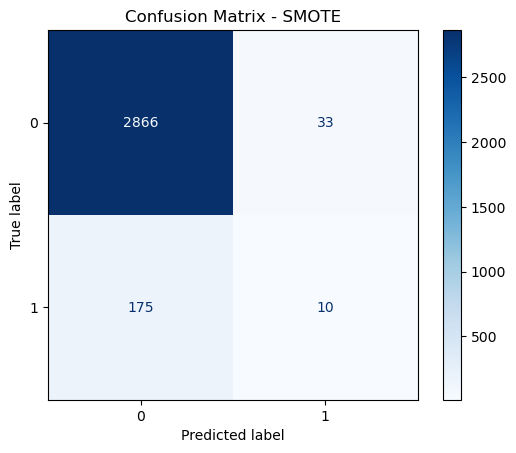

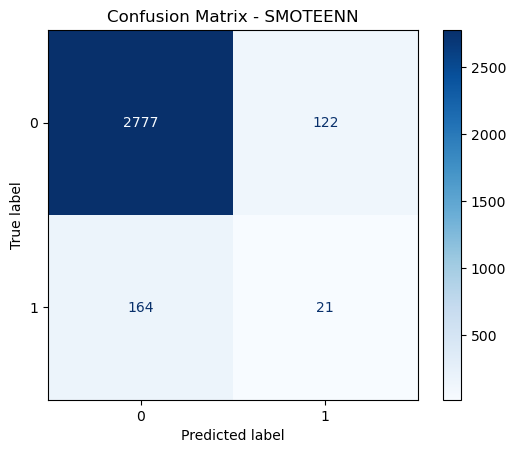

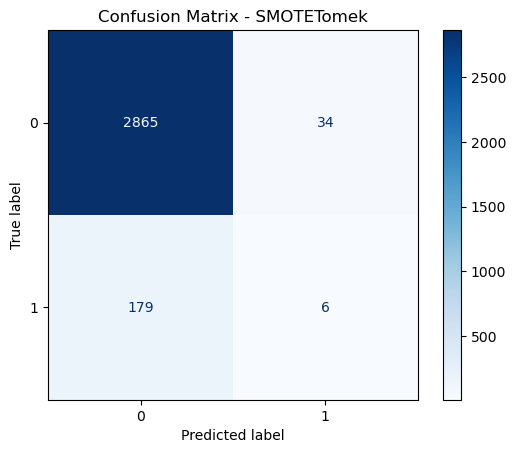

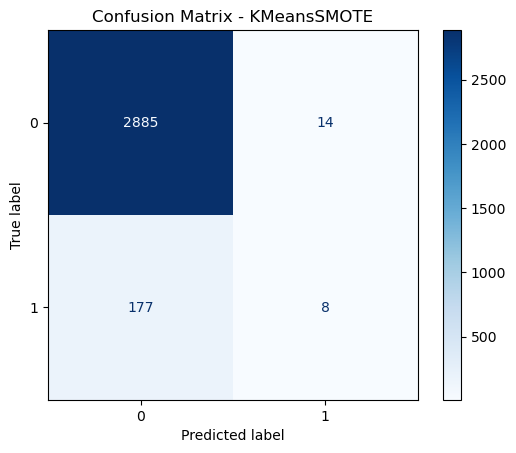

In [215]:
# Confusion matrices
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_test_numeric = X_test.select_dtypes(include=[np.number])

resampled_data = {
    "SMOTE": (X_train_smote, y_train_smote),
    "SMOTEENN": (X_train_smoteenn, y_train_smoteenn),
    "SMOTETomek": (X_train_smotetomek, y_train_smotetomek),
    "KMeansSMOTE": (X_train_kmeans, y_train_kmeans)
}

for name, (X_res, y_res) in resampled_data.items():
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_res, y_res)

    y_pred = clf.predict(X_test_numeric)
    cm = confusion_matrix(y_test, y_pred)

    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


**Confusion matrix**:
Examines the number of true positives, false negatives, false positives, and true negatives

A high recall (true positive rate) is important in fraud detection, but it is important to keep false positives under control so the system doesn’t flag too many legitimate claims

**Results**:
- SMOTEENN has the best tradeoff: moderately higher false positives (predicts fraud more aggressively) but fewer false negatives => better at detecting fraud
- SMOTE and SMOTETomek are too conservative: very few false positives but too many missed frauds
- KMeansSMOTE is even more conservative, leading to the lowest recall.

In [218]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

resampled_data = {
    "SMOTE": (X_train_smote, y_train_smote),
    "SMOTEENN": (X_train_smoteenn, y_train_smoteenn),
    "SMOTETomek": (X_train_smotetomek, y_train_smotetomek),
    "KMeansSMOTE": (X_train_kmeans, y_train_kmeans)
}

cv_results = {}

for name, (X_res, y_res) in resampled_data.items():
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(clf, X_res, y_res, cv=5, scoring='f1')
    cv_results[name] = {"F1-mean": scores.mean(), "F1-std": scores.std()}

cv_df = pd.DataFrame(cv_results).T
print(cv_df)


              F1-mean    F1-std
SMOTE        0.959371  0.063189
SMOTEENN     0.955748  0.057774
SMOTETomek   0.959338  0.063051
KMeansSMOTE  0.935954  0.073314


**Cross-Validation**: To check the average and variance of metrics across folds to ensure the method is robust

**Result**:
- SMOTEENN is the best choice in terms of both performance (highest F1-mean) and stability (lowest F1-std)
- SMOTE and SMOTETomek are close in performance but slightly less stable
- KMeansSMOTE is not suitable here due to poor and unstable F1 scores

In [223]:
# SMOTE
from imblearn.over_sampling import SMOTE

# Select only numeric columns
X_train_numeric = X_train.select_dtypes(include=[np.number])
y_train_numeric = y_train.astype(int)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_numeric, y_train_numeric)

print("After SMOTE shape:", X_train_smote.shape)
print("Class distribution after SMOTE:\n", pd.Series(y_train_smote).value_counts())


After SMOTE shape: (23196, 43)
Class distribution after SMOTE:
 FraudFound_P
0    11598
1    11598
Name: count, dtype: int64


In [226]:
keep_cols = X_train_smote.columns

In [230]:
X_test = X_test[keep_cols]

In [343]:
# Save unscaled dataset after resampling
X_train_smote.to_csv("../data/processed/x_train_smote.csv", index=False)
y_train_smote.to_csv("../data/processed/y_train_smote.csv", index=False)
X_test.to_csv("../data/processed/x_test.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

## Feature scaling

In [236]:
# Select only numerical features
num_cols = X_train_smote.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_smote[num_cols] = scaler.fit_transform(X_train_smote[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Check scaled data
X_train_smote[num_cols].head()

,WeekOfMonth,WeekOfMonthClaimed,Age,PolicyNumber,RepNumber,Deductible,DriverRating,Year,DaysToClaimRatio,AgeVehicleRatio,...,AccidentArea_encoded,Sex_encoded,MaritalStatus_encoded,Fault_encoded,VehiclePrice_encoded,PoliceReportFiled_encoded,WitnessPresent_encoded,AgentType_encoded,AddressChange_Claim_encoded,BasePolicy_encoded
0,0.234978,0.404249,-1.392571,0.174056,-0.507728,-0.195631,1.636300,0.220637,-0.086845,-0.613792,...,0.468707,0.474104,1.769346,2.419212,-0.514652,8.162525,-0.055017,-0.094195,-0.293431,-1.012403
1,0.234978,0.404249,-0.451680,0.466849,-0.984376,-0.195631,-1.263067,0.220637,-0.086845,-0.336821,...,0.468707,0.474104,-0.521697,2.419212,-0.514652,-0.122511,-0.055017,-0.094195,-0.293431,0.206516
2,-0.569770,-0.444499,0.489211,1.513412,-0.507728,-0.195631,1.636300,1.474717,-0.086845,-0.322972,...,0.468707,0.474104,-0.521697,-0.413358,0.919757,-0.122511,-0.055017,-0.094195,-0.293431,-1.012403
3,0.234978,0.404249,0.061534,1.656987,1.160540,-0.195631,-1.263067,1.474717,-0.086845,-0.322972,...,0.468707,0.474104,-0.521697,2.419212,-0.514652,-0.122511,-0.055017,-0.094195,-0.293431,0.206516
4,0.234978,2.101746,-0.964893,-0.119415,1.160540,-0.195631,-1.263067,0.220637,-0.086845,-0.032153,...,0.468707,0.474104,1.769346,-0.413358,-1.231856,-0.122511,-0.055017,-0.094195,-0.293431,1.425436


In [345]:
# Save scaled dataset after resampling
X_train_smote.to_csv("../data/processed/x_train_scaled.csv", index=False)
X_test.to_csv("../data/processed/x_test_scaled.csv", index=False)